# discrate_ds1


_This notebook describes results of first run of __[Discrate](https://github.com/tsgouvea/discrate/tree/309448f92ff401075592e49c7c32cb75fb58382a)__, a 2AFC task that pitches reward rate against immediacy. In each trial, rats chose freely between two choice ports with different pre- and post-choice delays. Reward probability is 0.5,_ iid _across trials._

In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
import scipy.io as sio
import scipy as sp
import statsmodels.api as sm
from IPython.display import display, HTML

from tasks import discrate

/Users/thiago/Programs/anaconda2/envs/tasksuite/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Load single sessions (Bpod .mat files stored in same repository as this notebook) and build pandas dataframes with session summary (**dataSumm**) and single trial (**dataSing**) data:

In [2]:
path_ds1 = 'datasets/discrate_ds1/'
listSubj = next(os.walk(path_ds1))[1]
listSubj.sort()
listSess = [[]]*len(listSubj);
dataSumm = [[]]*len(listSubj)
dataSing = [[]]*len(listSubj)

for iSubj in range(len(listSubj)) :
    subj = listSubj[iSubj]
    listSess[iSubj] = os.listdir(os.path.join(path_ds1,subj))
    listSess[iSubj].sort()
    dataSumm[iSubj] = discrate.multisess()
    dataSing[iSubj] = [[]]*len(listSess[iSubj])
    dates = [[]]*len(listSess[iSubj])

    for iSess in range(len(listSess[iSubj])) :
        sessName = listSess[iSubj][iSess]
        date = re.split('_',listSess[iSubj][iSess])
        dates[iSess] = date[2]
        mysess = sio.loadmat(os.path.join(path_ds1,subj,sessName), squeeze_me=True)
        parsed = discrate.parser(mysess)
        parsed.parse()
        dataSumm[iSubj].append(parsed)
        dataSing[iSubj][iSess] = parsed.parsedData
        
    dataSumm[iSubj].summary.index = dates

/Users/thiago/Documents/TaskSuite/tasks/discrate.py:166: RuntimeWarning: divide by zero encountered in double_scalars
  logOdds = np.log(pLeft/(1-pLeft))
/Users/thiago/Documents/TaskSuite/tasks/discrate.py:166: RuntimeWarning: divide by zero encountered in log
  logOdds = np.log(pLeft/(1-pLeft))


## Response rate depends on pre- and post-reward delays

Plot figure 1:

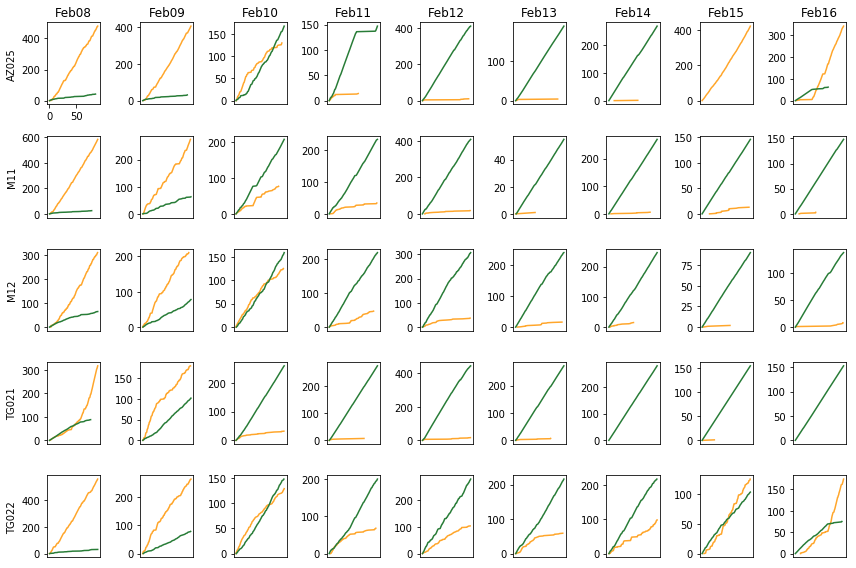

In [3]:
hf, hsps = plt.subplots(len(listSubj),len(listSess[iSubj]),figsize=(12,8))

for iSubj in range(len(listSubj)) :
    for iSess in range(len(listSess[iSubj])) :
        plt.subplot(len(listSubj),len(listSess[iSubj]),1 + (iSubj*len(listSess[iSubj])) + iSess)

        ndxChoL = dataSing[iSubj][iSess].ChoiceLeft.values
        ndxChoR = np.logical_not(ndxChoL)
        #hrate.set_xlabel('Time (min) from session start', fontsize=7)
        #hrate.set_ylabel('Cumulative trial count', fontsize=7)
        plt.plot(np.asarray(dataSing[iSubj][iSess].tsState0.values[ndxChoL]-dataSing[iSubj][iSess].tsState0.values[0])/60,np.arange(np.sum(ndxChoL)), color='xkcd:mango')
        plt.plot(np.asarray(dataSing[iSubj][iSess].tsState0.values[ndxChoR]-dataSing[iSubj][iSess].tsState0.values[0])/60,np.arange(np.sum(ndxChoR)), color='xkcd:darkish green')
        
        #print(str(iSess) + ' ' + str(iSubj))
        if (iSess > 0 or iSubj > 0) :
            #print('0 and 0')
            plt.xticks([])
            #plt.yticks([])
            
        if iSess == 0 :
            plt.ylabel(listSubj[iSubj])
            
        if iSubj == 0 :
            date = re.split('_',listSess[iSubj][iSess])
            plt.title(date[2])

plt.tight_layout()

__Figure 1: Response rates__ Cumulative sum of responses at left (yellow) and right (green) choice ports as a function of time since session start. All sessions lasted 90 min. n = 5 subjects, 9 sessions each.

Display pre- and post- reward delays used in each session:

In [ ]:
for iSubj in range(len(listSubj)) :
    display(dataSumm[iSubj].summary[dataSumm[iSubj].summary.columns[::-1]])    

**Table 1: Delays** Delays pre- and post- left and right choices, fraction of left choices, and log odds of choices

In [ ]:
ndxPred = dataSumm[iSubj].summary.columns[3:5]
print('Predictors:')
print(ndxPred)

ndxResp = dataSumm[iSubj].summary.columns[0:1]
print('Response variable:')
print(ndxResp)

X = dataSumm[iSubj].summary.loc[:,ndxPred]
y = dataSumm[iSubj].summary.loc[:,ndxResp]

In [ ]:
#sp.stats.zscore(X)
ndxPred
sp.stats.zscore(X)

In [ ]:
plt.scatter(X['preL'],X['posR'])
plt.xlabel('preL')
plt.ylabel('posR')

In [ ]:
#STATSMODELS
#X = sm.add_constant(X)
mdl = [[]]*len(listSubj)
for iSubj in range(len(listSubj)) :
    X = dataSumm[iSubj].summary.loc[:,ndxPred]
    X = sm.add_constant(X)
    y = dataSumm[iSubj].summary.loc[:,ndxResp]
    mdl[iSubj] = sm.OLS(y,X).fit()
    mdl[iSubj].summary()

In [ ]:
mdl[2].summary()

In [ ]:
#STATSMODELS
X = dataSumm[iSubj].summary.loc[:,ndxPred]
y = dataSumm[iSubj].summary.loc[:,ndxResp]
X = sm.add_constant(X)
mdl = sm.OLS(y,X).fit()
mdl.summary()

In [ ]:
#SKLEARN
mdl.fit(X,y)
print(X)
print(y)
print(mdl.coef_)

In [ ]:
mdl = skl.LinearRegression(fit_intercept=False)

ndxPred = dataSumm[iSubj].summary.columns[2:]
ndxResp = dataSumm[iSubj].summary.columns[0:1]

X = dataSumm[iSubj].summary.loc[:,ndxPred]
y = dataSumm[iSubj].summary.loc[:,ndxResp]
mdl.fit(X,y)
print(X)
print(y)
print(mdl.coef_)

In [ ]:
mdl.predict(X)
plt.scatter(mdl.predict(X),y)

In [ ]:
bigmatrix = pd.DataFrame()
for i in range(len(dataSing)):
    for j in range(len(dataSing[i])):
        pass
#        dataSing[i][j].parsedData
#        bigmatrix = bigmatrix.append()

temp = dataSumm[i].summary.loc[j,:]
temp
#pd.concat(dataSing[i][j].parsedData,pd.DataFrame({}))

In [ ]:
print(listSess[iSubj][iSess])
dataSumm[iSubj].summary

In [ ]:
ds = dataSumm[iSubj].summary
y = ds['pLeft']
y2 = np.log(y/(1-y))
y

In [ ]:
ds.loc[:,[n.endswith('L') for n in ds.columns]].sum(axis=1) - ds.loc[:,[n.endswith('R') for n in ds.columns]].sum(axis=1)


In [ ]:
iSubj = 0
X = dataSumm[iSubj].summary.loc[:,dataSumm[iSubj].summary.columns[1:]]
y = dataSumm[iSubj].summary.loc[:,dataSumm[iSubj].summary.columns[0]]
X
#glm = LogisticRegression.fit(X,y)

In [ ]:
plt.scatter()